## Project 1: US Traffic Accidents

### Overview

This project performs a deep-dive diagnostic analysis of large-scale traffic accident data across the United States. Utilizing a dataset of millions of accident records, the study employs Python (Pandas, PySpark) for heavy-duty data processing and Matplotlib/Seaborn for exploratory visualization.

The goal is to transition from descriptive analytics (what happened) to prescriptive insights (what should be done). The final deliverables include a reproducible computational notebook, an interactive Tableau Dashboard for spatial exploration, and a strategic briefing for DOT stakeholders.

### Business Understanding

1. **The Challenge**

    Traffic fatalities and road accidents represent a significant public health crisis and a massive economic burden, costing billions in property damage, healthcare, and lost productivity. The Department of Transportation (DOT) faces the challenge of allocating limited resources—such as highway patrols, infrastructure upgrades, and emergency response teams—across a vast national network. Without data-driven prioritization, interventions are often reactive rather than proactive.

2. **Primary Objective**

    The objective of this analysis is to identify the high-risk variables that contribute to accident frequency and severity. By uncovering hidden patterns in temporal trends, weather impacts, and infrastructure flaws, we aim to provide the DOT with three high-impact, data-driven recommendations to:

    - **Reduce Accident Frequency**: By identifying "hotspots" and high-risk time windows.

    - **Mitigate Severity**: By understanding which environmental or infrastructural factors lead to fatal outcomes versus minor collisions.

    - **Optimize Resource Allocation**: Providing a blueprint for where the DOT should implement safety measures (e.g., improved lighting, signage, or traffic calming).

3. **Key Stakeholders**

    - Department of Transportation (DOT) Executives, Urban Planners & Engineers & Public Safety Officials

### Data Understanding

In [1]:
# Initializing the SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local').appName('Accidents Analysis Project').getOrCreate()

***Note***: This code helps us naviagte to our file directory so that we can access the data.

In [2]:
import os

print("Current Directory:", os.getcwd(), '\n')
print("Files in directory:", os.listdir('./work'))

Current Directory: /home/jovyan 

Files in directory: ['.git', '.gitignore', '.ipynb_checkpoints', 'data', 'README.md', 'us_traffic_accidents_analysis.ipynb']


In [3]:
spark_df = spark.read.csv('./work/data/US_Accidents_March23.csv', inferSchema=True, header=True) 

In [4]:
# Verifying the data types within the dataset.

spark_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [5]:
# Counting the total record in the dataset

print(f"Total Accidents in Dataset: {spark_df.count()}")

Total Accidents in Dataset: 7728394


***Note***: The columns below are insignificant for our analysis which is why I've decided to exclude it from our further analysis. Also, some columns have redundant values as it can be described by another column. 

In [6]:
# List of columns that don't add value to the safety analysis. Also, some reduntant columns --to remove.

cols_to_drop = [
    'Source', 'End_Lat', 'End_Lng', 'Description',        
    'Street', 'Country', 'Timezone', 'Airport_Code',
    'Weather_Timestamp', 'Wind_Chill(F)', 'Wind_Direction',        
    'Wind_Speed(mph)', 'Pressure(in)', 'Civil_Twilight',        
    'Nautical_Twilight', 'Astronomical_Twilight', 'Turning_Loop',            
    'Bump', 'Give_Way', 'No_Exit', 'Roundabout'    
]

df_lean = spark_df.drop(*cols_to_drop)
df_lean.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Amenity: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Calming: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullab

***Note***: This helps us get a quick summary for all our numeric columns.

In [7]:
# Selecting all the numerical columns in our dataset 
num_cols = [col for col, data_type in df_lean.dtypes if data_type in ['int', 'double']]

# General statistics for our numerical columns
df_lean.select(num_cols).summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+
|summary|          Severity|         Start_Lat|         Start_Lng|      Distance(mi)|    Temperature(F)|       Humidity(%)|   Visibility(mi)|   Precipitation(in)|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+
|  count|           7728394|           7728394|           7728394|           7728394|           7564541|           7554250|          7551296|             5524808|
|   mean| 2.212384487643875| 36.20119454946952|-94.70254538794683|0.5618422831523706| 61.66328580940991| 64.83104146672403|9.090376447963413|0.008407209807109432|
| stddev|0.4875313339360398| 5.076079113874013| 17.39175625334916|1.7768106031970923|19.013653291093142|22.820967660113475| 2.68831592141714| 0.11022464885795538|
|    min|             

In [8]:
from pyspark.sql import functions as F

# Counting nulls for every column

null_counts = df_lean.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_lean.columns])
null_counts.show()

+---+--------+----------+--------+---------+---------+------------+----+------+-----+-------+--------------+-----------+--------------+-----------------+-----------------+-------+--------+--------+-------+-------+----+---------------+--------------+--------------+
| ID|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|City|County|State|Zipcode|Temperature(F)|Humidity(%)|Visibility(mi)|Precipitation(in)|Weather_Condition|Amenity|Crossing|Junction|Railway|Station|Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|
+---+--------+----------+--------+---------+---------+------------+----+------+-----+-------+--------------+-----------+--------------+-----------------+-----------------+-------+--------+--------+-------+-------+----+---------------+--------------+--------------+
|  0|       0|         0|       0|        0|        0|           0| 253|     0|    0|   1915|        163853|     174144|        177098|          2203586|           173459|      0|       0|       0|      0|

### Findings - Report

The above analystical findings reveals the following data findings: 

1. **Missing Values**

    Here, some columns seems to be fully populated like (**Severity** and **Distance(mi)**) while others are missing some values. 

2. **Identifying Outliers**

    Some columns shows extreme values like the max **Temperature(F)** being 207.0, **Distance(mi)** being 140.0, **Visibility(mi)** being 140.0 which are not physically possible. We can look into those values as these values tends to skew our data by a lot.

3. **Distribution Insights**

    From the distribution of our data, we can find that for **Severity**, the mean is 2.21 so, the vast majority of accidents in your dataset are "Level 2" severity. Also, for the **Distance(mi)** column, the discrepency betweeen the mean and the median indicates a highly right-skewed distribution -most accidents are local, but a few massive outliers are pulling the average up.




**"Preliminary EDA revealed physical anomalies in weather data (e.g., temperatures exceeding \$200 F). To maintain statistical rigor, records with temperatures outside the realistic range of $-40 F to $120 F were filtered out. Additionally, the extreme skewness in 'Distance' suggests that median values should be used over means when discussing typical accident impact areas."**

In [9]:
df_lean.head()

Row(ID='A-1', Severity=3, Start_Time=datetime.datetime(2016, 2, 8, 5, 46), End_Time=datetime.datetime(2016, 2, 8, 11, 0), Start_Lat=39.865147, Start_Lng=-84.058723, Distance(mi)=0.01, City='Dayton', County='Montgomery', State='OH', Zipcode='45424', Temperature(F)=36.9, Humidity(%)=91.0, Visibility(mi)=10.0, Precipitation(in)=0.02, Weather_Condition='Light Rain', Amenity=False, Crossing=False, Junction=False, Railway=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, Sunrise_Sunset='Night')

### Data Preparation

***Note***: Here, we're applying a sanity filter to clean our dataset of the potential outliers while maintaing the integrity for each columns within our dataset. 

- **Temperature**: Here, the realistic temperature in the US ranges between -40 and 120 Fahrenheit.  

- **Visibility**: Cap it at $20$ miles (anything above this is "perfect" visibility and doesn't change driver behavior).

- **Distance**: We filter out incidents over $50$ miles to remove those $441$-mile outliers that represent long-term road closures rather than specific accident sites.

Also, the missing/ Null values in **Percipitation(in)** column might be because of the sensor reading error which is why we can use the 0.0 for those values. 

In [10]:
from pyspark.sql import functions as F

# Applying a 'Sanity Filter' based on our EDA findings

df_cleaned = df_lean.filter(
    (F.col("Temperature(F)").between(-40, 120)) &
    (F.col("Visibility(mi)") <= 20) &
    (F.col("Distance(mi)") < 50)
)

# Filling missing Precipitation with 0.0 for the Null values.

df_cleaned = df_cleaned.fillna({'Precipitation(in)': 0.0})

print(f"Rows retained after cleaning: {df_cleaned.count()}")

Rows retained after cleaning: 7514518


In [11]:
# Quickly checking the new limits

df_cleaned.select("Temperature(F)", "Visibility(mi)", "Distance(mi)").summary("min", "max", "mean").show()

+-------+----------------+-----------------+------------------+
|summary|  Temperature(F)|   Visibility(mi)|      Distance(mi)|
+-------+----------------+-----------------+------------------+
|    min|           -40.0|              0.0|               0.0|
|    max|           120.0|             20.0| 49.97999954223633|
|   mean|61.6921697572617|9.049525489193096|0.5507940778166458|
+-------+----------------+-----------------+------------------+



In [12]:
# Calculating the nulls for each column in our cleaned dataset

null_counts_cleaned = df_cleaned.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) 
    for c in df_cleaned.columns
])

null_counts_cleaned.show()

+---+--------+----------+--------+---------+---------+------------+----+------+-----+-------+--------------+-----------+--------------+-----------------+-----------------+-------+--------+--------+-------+-------+----+---------------+--------------+--------------+
| ID|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|City|County|State|Zipcode|Temperature(F)|Humidity(%)|Visibility(mi)|Precipitation(in)|Weather_Condition|Amenity|Crossing|Junction|Railway|Station|Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|
+---+--------+----------+--------+---------+---------+------------+----+------+-----+-------+--------------+-----------+--------------+-----------------+-----------------+-------+--------+--------+-------+-------+----+---------------+--------------+--------------+
|  0|       0|         0|       0|        0|        0|           0| 244|     0|    0|      0|             0|      10096|             0|                0|            16445|      0|       0|       0|      0|

***Note***: Here, we're trying to impute the null values within these categorical columns with the 'Unknown' category type.

In [13]:
# Filling remaining categorical nulls with 'Unknown'

df_final = df_cleaned.fillna({
    'Weather_Condition': 'Unknown',
    'Sunrise_Sunset': 'Unknown',
    'City': 'Unknown'
})

# Verifying the change for one of them
print(f"Remaining nulls in Weather_Condition: {df_final.filter(F.col('Weather_Condition').isNull()).count()}")

Remaining nulls in Weather_Condition: 0


***Note***: Here, we're using the median value from the **Humidity(%)** column by taking the sample i.e. 1% of the data from that column to impute in place for null values.

In [14]:
# Imputing the numerical column i.e. Humidity(%) which has 10096 missing values with the median value.

# Calculating the median humidity
median_humidity = df_final.approxQuantile("Humidity(%)", [0.5], 0.01)[0]

# Filling the nulls
df_final = df_final.fillna({'Humidity(%)': median_humidity})

### Exploratory Data Analysis

In [15]:
# importing libraries

import matplotlib.pyplot as plt

### 1. Feature Engineering: The Temporal Extraction

In [16]:
from pyspark.sql import functions as F

# Creating the temporal features
df_final = df_final.withColumn("Hour", F.hour("Start_Time")) \
                   .withColumn("DayOfWeek", F.dayofweek("Start_Time")) \
                   .withColumn("Month", F.month("Start_Time")) \
                   .withColumn("Year", F.year("Start_Time"))

# A quick look to verify the transformation
df_final.select("Start_Time", "Hour", "DayOfWeek", "Month").show(5)

+-------------------+----+---------+-----+
|         Start_Time|Hour|DayOfWeek|Month|
+-------------------+----+---------+-----+
|2016-02-08 05:46:00|   5|        2|    2|
|2016-02-08 06:07:59|   6|        2|    2|
|2016-02-08 06:49:27|   6|        2|    2|
|2016-02-08 07:23:34|   7|        2|    2|
|2016-02-08 07:39:07|   7|        2|    2|
+-------------------+----+---------+-----+
only showing top 5 rows



### I. Grouping by Hour

***Note***: This helps us identify the rush-hour patterns in order to identify which hours of the day have the highest volume of accidents. ALso, the DOT wants to know when interventions are needed

In [17]:
# Grouping by Hour to see the distribution
hourly_stats = df_final.groupBy("Hour").count().orderBy("Hour")

# Converting to Pandas for a quick local check and visualization
hourly_stats = hourly_stats.toPandas()
print(hourly_stats)

    Hour   count
0      0  108256
1      1   93544
2      2   89705
3      3   80806
4      4  154661
5      5  220832
6      6  393600
7      7  571559
8      8  561770
9      9  352857
10    10  333106
11    11  345477
12    12  345432
13    13  385479
14    14  436886
15    15  512714
16    16  568394
17    17  562467
18    18  421186
19    19  287282
20    20  218559
21    21  185500
22    22  162280
23    23  122166


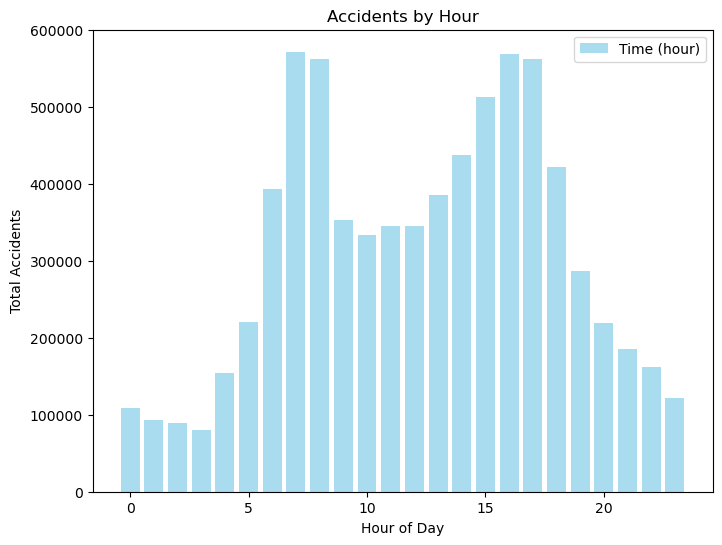

In [18]:
# Bar Plot for the hourly_stats

plt.figure(figsize=(8, 6))
plt.bar(hourly_stats['Hour'], hourly_stats['count'], color='skyblue', alpha=0.7, label='Time (hour)')

plt.title('Accidents by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Accidents')
plt.legend()
plt.show()

**Analysis**

From the bar chart, we can see that it shows a massive, sharp spike between 6:00 AM to 8:00 AM and 3:00 PM to 5:00 PM.

- The Peak: 7:00 AM with over (571k) and 4:00 PM with over (568k) accidents are the "deadliest" hours.

- The Drop: we can notice that the count drops significantly at 9:00 AM.

- DOT Policy Insight: Our dataset suggests that the Morning Rush is significantly more compressed and dangerous than the evening commute. While the morning peak is a sharp spike, the afternoon/evening risk (3 PM – 5 PM) is very sustained. This suggests that while morning accidents are driven by a "rush," afternoon accidents might be driven by a combination of volume and driver fatigue at the end of the workday. Safety interventions should be prioritized for the sunrise hours. 

### II. Grouping by Day of Week

***Note***: This provides us the average severity based on the days of the week so that we can compare between the weekdays and the weekends.

In [19]:
# Grouping by Day of Week
daily_stats = df_final.groupBy("DayOfWeek").agg(
    F.count("ID").alias("Accident_Count"),
    F.avg("Severity").alias("Average_Severity")
).orderBy("DayOfWeek")

# Converting to Pandas
daily_stats = daily_stats.toPandas()
print(daily_stats)

   DayOfWeek  Accident_Count  Average_Severity
0          1          540080          2.259328
1          2         1178754          2.207745
2          3         1257245          2.203792
3          4         1278921          2.201747
4          5         1282468          2.202573
5          6         1329679          2.204977
6          7          647371          2.239674


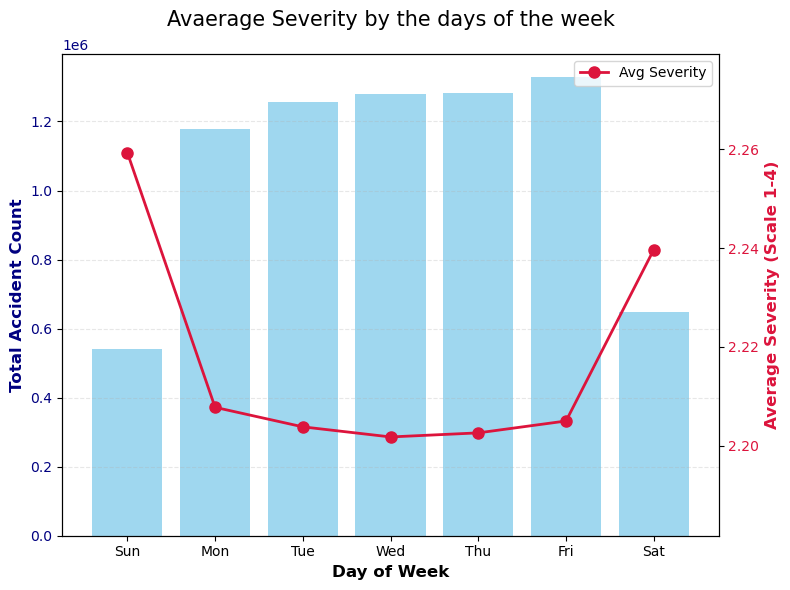

In [20]:
# Mapping the numeric days to the 'day' name.
day_map = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
daily_stats['Day_Name'] = daily_stats['DayOfWeek'].map(day_map)

# Creating a bar plot
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.bar(daily_stats['Day_Name'], daily_stats['Accident_Count'], color='skyblue', alpha=0.8, label='Accident Count')

ax1.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Accident Count', color='navy', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='navy')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Creating a second axis for Severity that shares the same x-axis
ax2 = ax1.twinx() 
ax2.plot(daily_stats['Day_Name'], daily_stats['Average_Severity'], color='crimson', marker='o', linewidth=2, markersize=8, label='Avg Severity')

ax2.set_ylabel('Average Severity (Scale 1-4)', color='crimson', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='crimson')

# Zoom the severity axis to make the difference visible (range 2.15 to 2.30)
ax2.set_ylim(daily_stats['Average_Severity'].min() - 0.02, daily_stats['Average_Severity'].max() + 0.02)

plt.title('Avaerage Severity by the days of the week', fontsize=15, pad=20)
plt.legend()
plt.tight_layout()
plt.show()

**Analysis**

From the chart, we can find that it represents a classic case of "High Volume vs. High Risk" scenario. We can find that:

- **Volume**: Tuesday through Friday see the highest number of accidents (over 1.2 million each).

- **Severity**: Looking at the weekends, we can find that the accident counts are almost half of what they are on a weekdays nevertheless, the average severity jumps to 2.25 and 2.23.

- **Analytical Insight**: Weekdays are "High Frequency/Lower Impact". Weekends are "Low Frequency/Higher Impact." This suggests that when roads are clearer, speeds are higher, leading to more severe injuries when a crash does happen.

### III. Grouping by Month

***Note***: This identifies the seasonal aspect for our analysis by grouping by month. 

In [21]:
# Grouping by Month
monthly_counts = df_final.groupBy("Month").count().orderBy("Month")

monthly_counts = monthly_counts.toPandas()
print(monthly_counts)

    Month   count
0       1  729009
1       2  641749
2       3  541111
3       4  575063
4       5  546141
5       6  553755
6       7  495680
7       8  583501
8       9  632861
9      10  657960
10     11  735893
11     12  821795


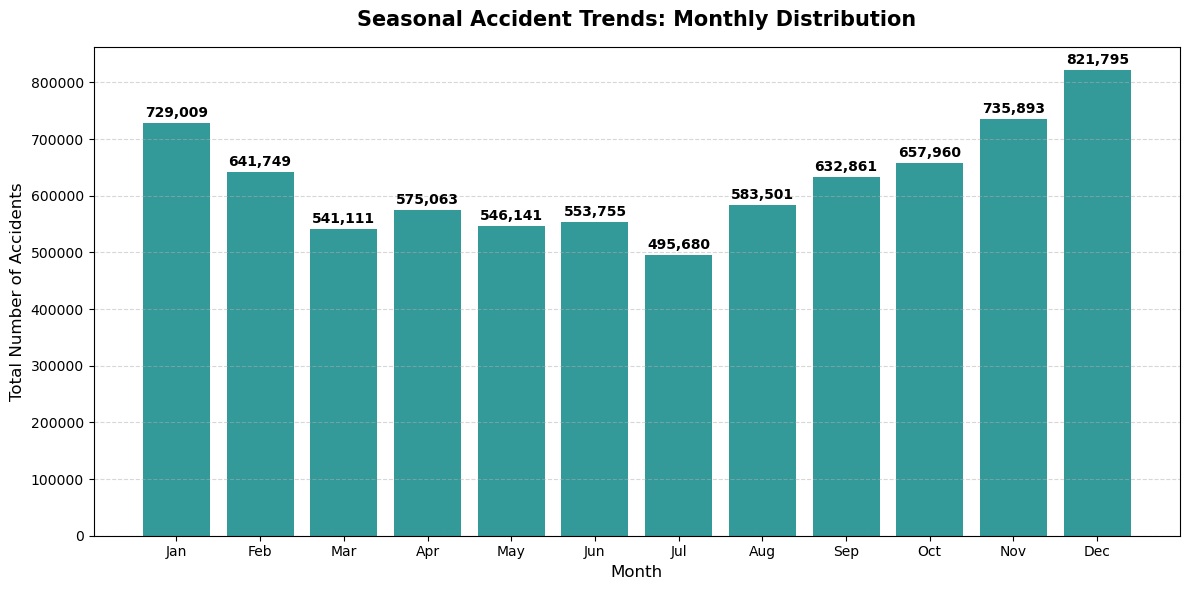

In [47]:
# Mapping to the corresponding month name for the 'Month' numeric representative column.
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
monthly_counts['Month_Name'] = monthly_counts['Month'].map(month_map)

# Creating a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_counts['Month_Name'], monthly_counts['count'], color='teal', alpha=0.8)

plt.title('Seasonal Accident Trends: Monthly Distribution', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Number of Accidents', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding the labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5000, f'{int(yval):,}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**Analysis**

 The monthly data reveals a clear "U-Shaped" seasonal trend.

- **The Highs**: December (821,795) and January (729,009) are the peak months.

- **The Lows**: July (495,680) is the safest month.

- **Insight**: There is an increase in number of accidents in December compared to July. This strongly supports the need for Environmental Analysis, as winter weather (snow, ice, less daylight) is likely the driving factor here.

##### Policy Recommendation: Since accidents are nearly 65% higher in December than in July, the DOT should allocate seasonal safety resources (like salt trucks, highway patrols, and public awareness campaigns) starting in late October to mitigate the year-end surge.

### 2. Environmental Factors Analysis

In [54]:
df_final.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- City: string (nullable = false)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = false)
 |-- Visibility(mi): double (nullable = true)
 |-- Precipitation(in): double (nullable = false)
 |-- Weather_Condition: string (nullable = false)
 |-- Amenity: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Calming: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nu

In [48]:
df_final.head()

Row(ID='A-1', Severity=3, Start_Time=datetime.datetime(2016, 2, 8, 5, 46), End_Time=datetime.datetime(2016, 2, 8, 11, 0), Start_Lat=39.865147, Start_Lng=-84.058723, Distance(mi)=0.01, City='Dayton', County='Montgomery', State='OH', Zipcode='45424', Temperature(F)=36.9, Humidity(%)=91.0, Visibility(mi)=10.0, Precipitation(in)=0.02, Weather_Condition='Light Rain', Amenity=False, Crossing=False, Junction=False, Railway=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, Sunrise_Sunset='Night', Hour=5, DayOfWeek=2, Month=2, Year=2016)

In [53]:
df_final.select('Weather_condition').distinct().count()

144

In [55]:
spark.stop()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
/usr/local/spark/python/pyspark/context.py:657: RuntimeWarning: Unable to cleanly shutdown Spark JVM process. It is possible that the process has crashed, been killed or may also be

ConnectionRefusedError: [Errno 111] Connection refused

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


### Analysis

### Evaluation

### Business Insight/Recommendation 1

### Business Insight/Recommendation 2

### Business Insight/Recommendation 3

##### Tableau Dashboard link

### Conclusion and Next Steps